#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

# **Packages**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/BA780 Team Project/bitcoin.csv") 

Modify Timestamp

In [3]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')
df = df.resample("6H").mean()

Spot the missing values

In [6]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [7]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [8]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [9]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

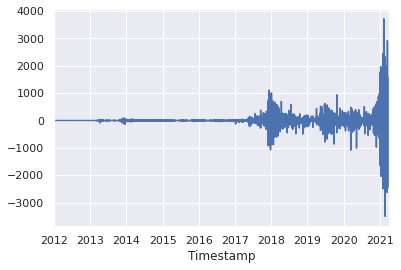

In [10]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [11]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

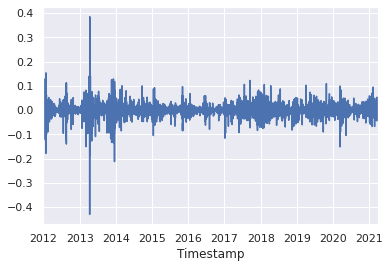

In [12]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [13]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 12:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,141.106779,4.498804,4.501667,0.111667,Up,0.025437,0.008700,0.008625,0.028384,0.027601,0.033058
2011-12-31 18:00:00,4.535000,4.546667,4.535000,4.546667,16.561383,73.992970,4.539402,4.540833,0.039167,Up,0.008700,0.008625,0.028384,0.027601,0.033058,0.000000
2012-01-01 00:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,6.879160,4.580000,4.580000,0.039167,Up,0.008625,0.028384,0.027601,0.033058,0.000000,0.000000
2012-01-01 06:00:00,4.710000,4.710000,4.710000,4.710000,5.751000,27.639580,4.710000,4.710000,0.130000,Up,0.028384,0.027601,0.033058,0.000000,0.000000,0.000000
2012-01-01 12:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,48.400000,4.840000,4.840000,0.130000,Up,0.027601,0.033058,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28 18:00:00,55296.091253,55325.175627,55265.948858,55295.153565,2.293634,126573.975670,55293.591871,55295.592326,-598.025744,Down,-0.010699,0.000659,0.026535,0.019644,-0.005456,-0.003950
2021-03-29 00:00:00,55332.725434,55353.133641,55310.640196,55331.700000,1.222379,67518.219699,55330.418632,55332.049818,36.457492,Up,0.000659,0.026535,0.019644,-0.005456,-0.003950,0.017309
2021-03-29 06:00:00,56795.977855,56835.699443,56766.544011,56802.929749,5.425811,309065.217746,56801.267776,56800.287765,1468.237947,Up,0.026535,0.019644,-0.005456,-0.003950,0.017309,0.008711


Cleaned Dataset Display

In [ ]:
df.shape

(4857377, 16)

In [ ]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0


#**Exploratory Data Analysis**

Zheming's Part

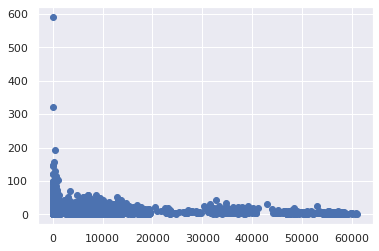

In [15]:
X = df[['Price']]
y = df[['Volume_(BTC)']]
plt.scatter(X, y);

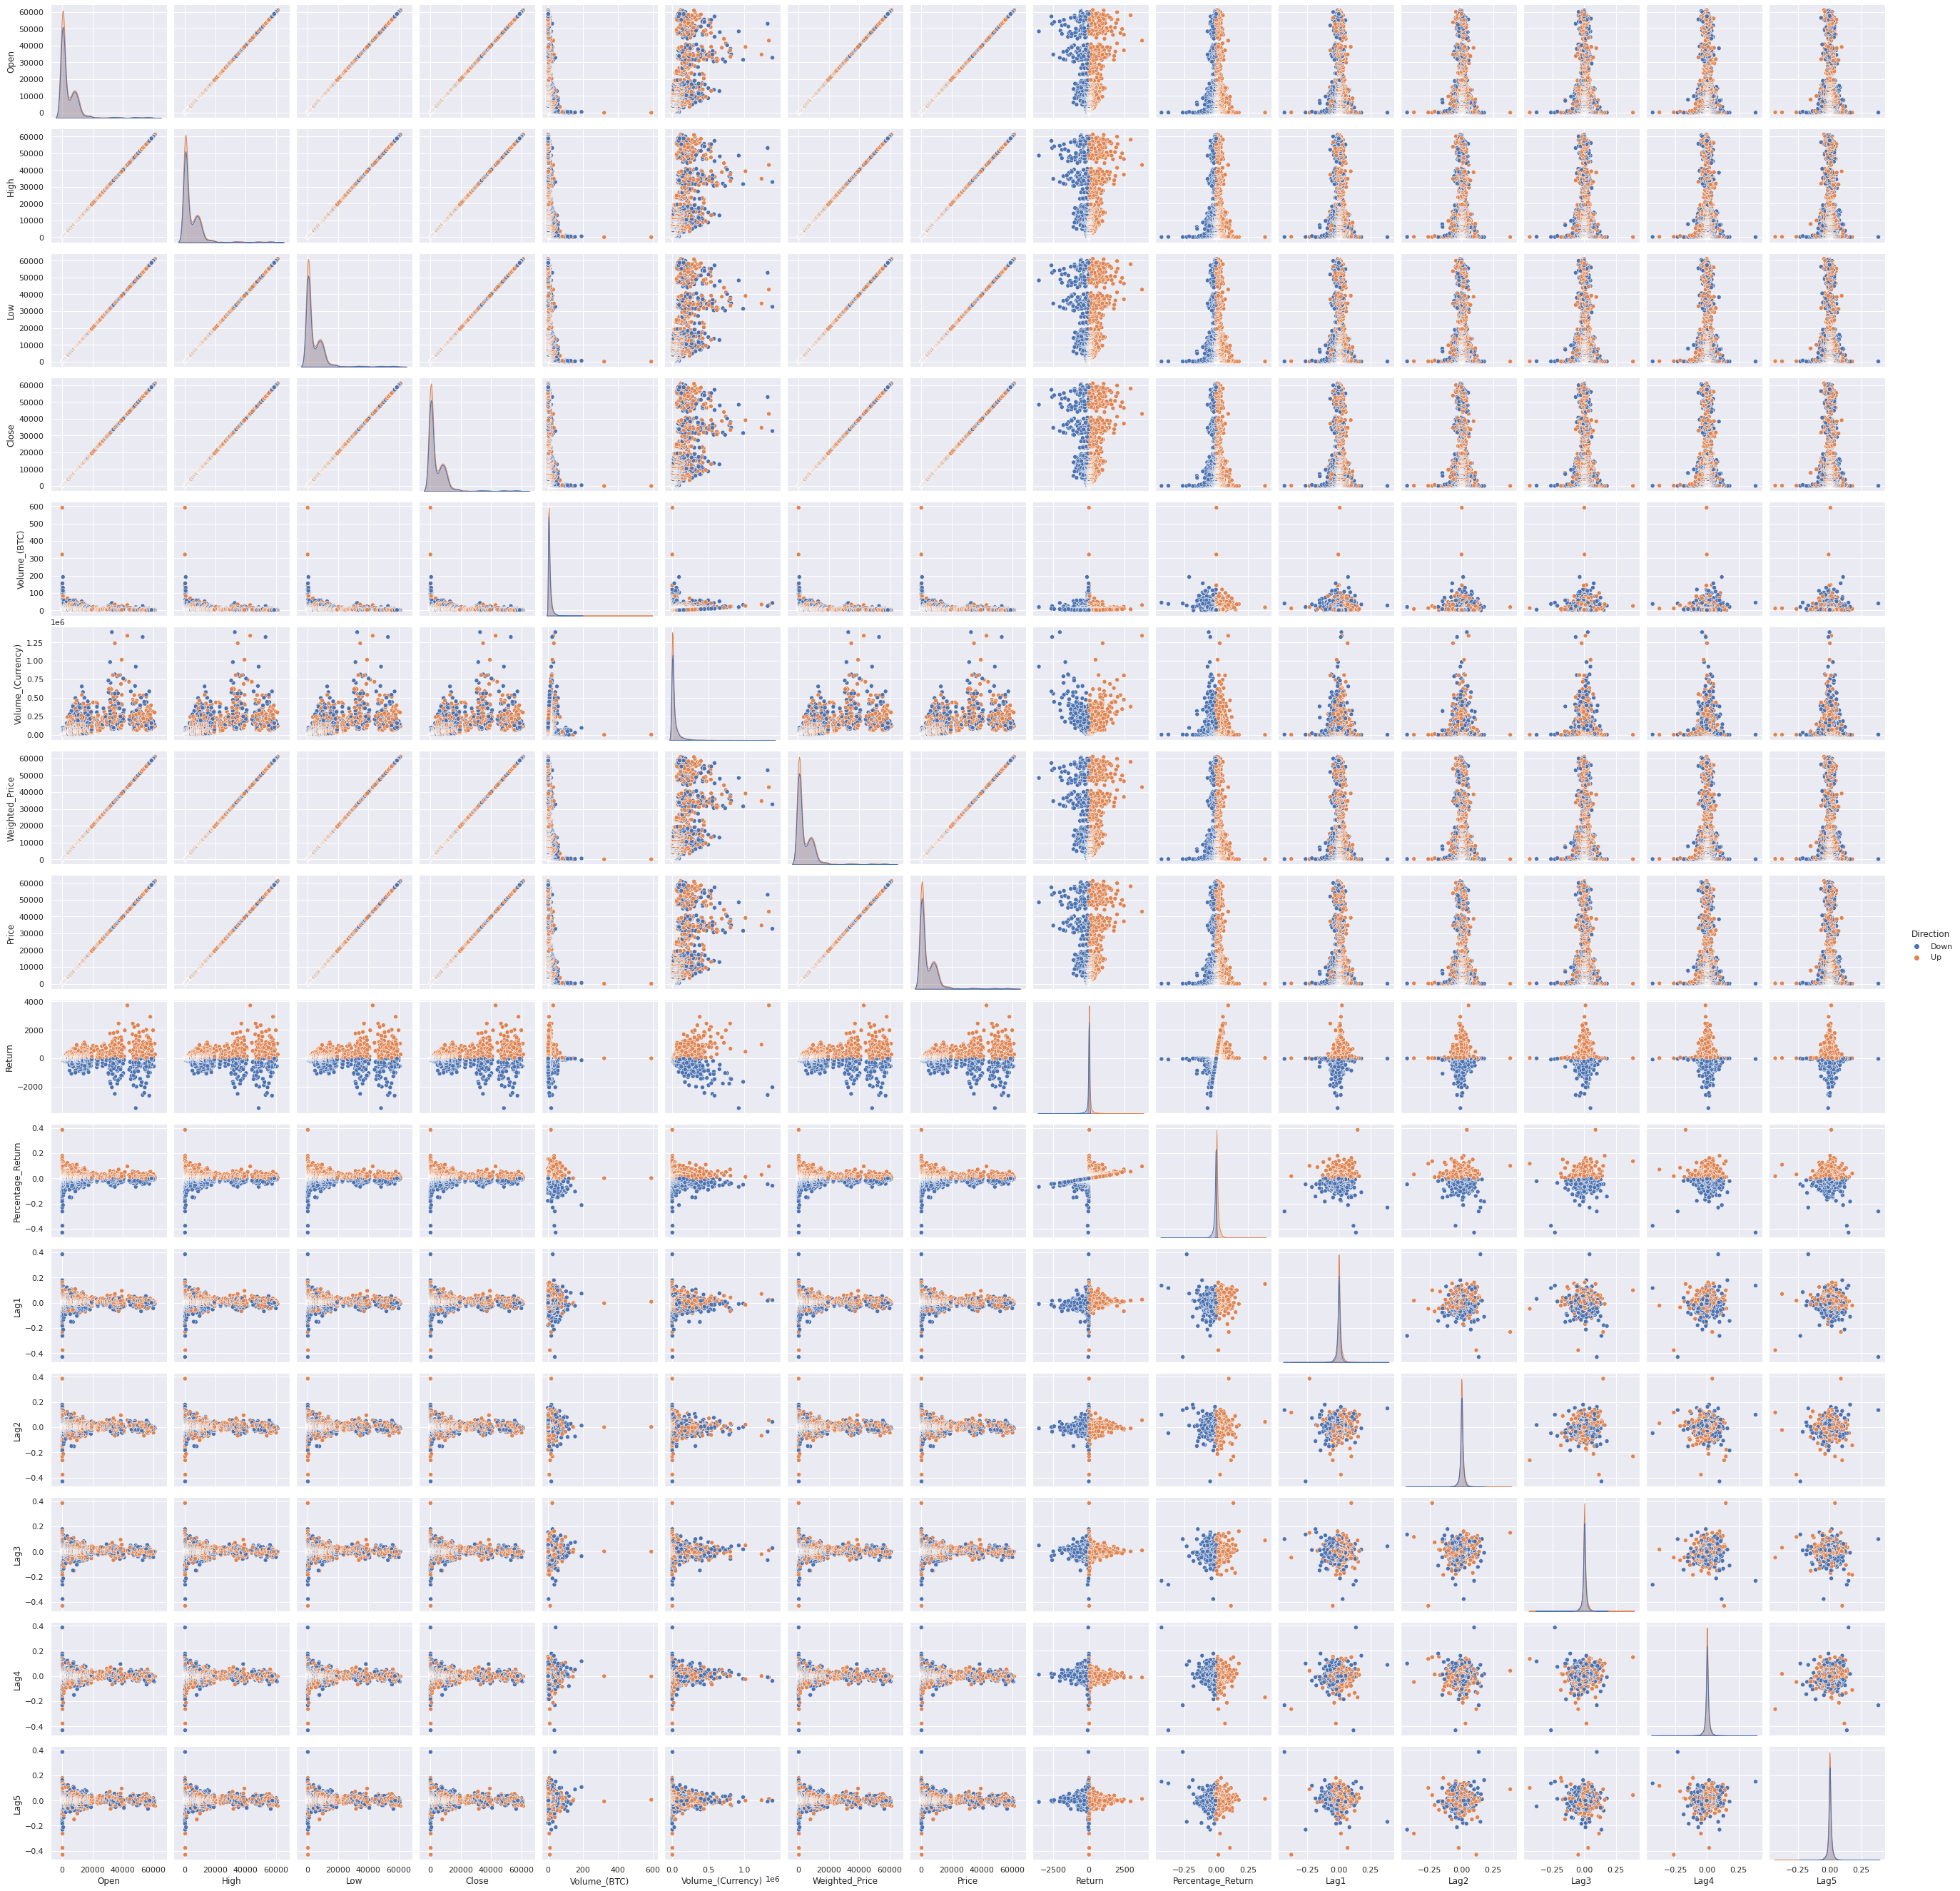

In [14]:
sns.pairplot(df, hue='Direction', height=2.5);

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

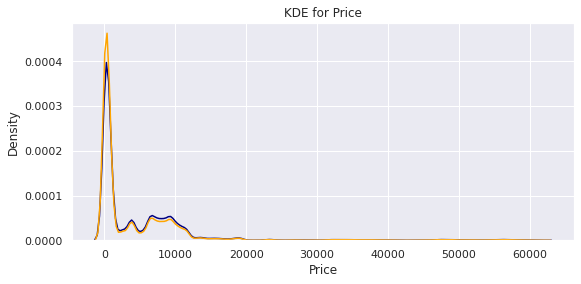

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

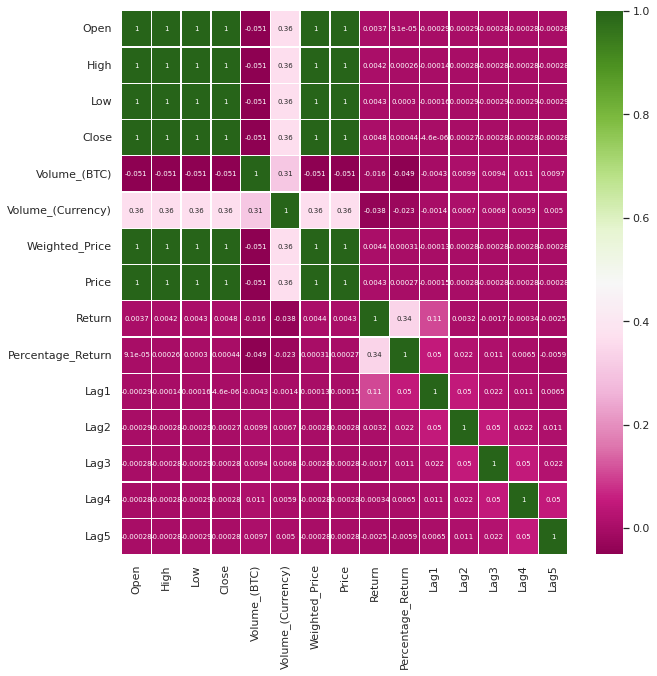

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


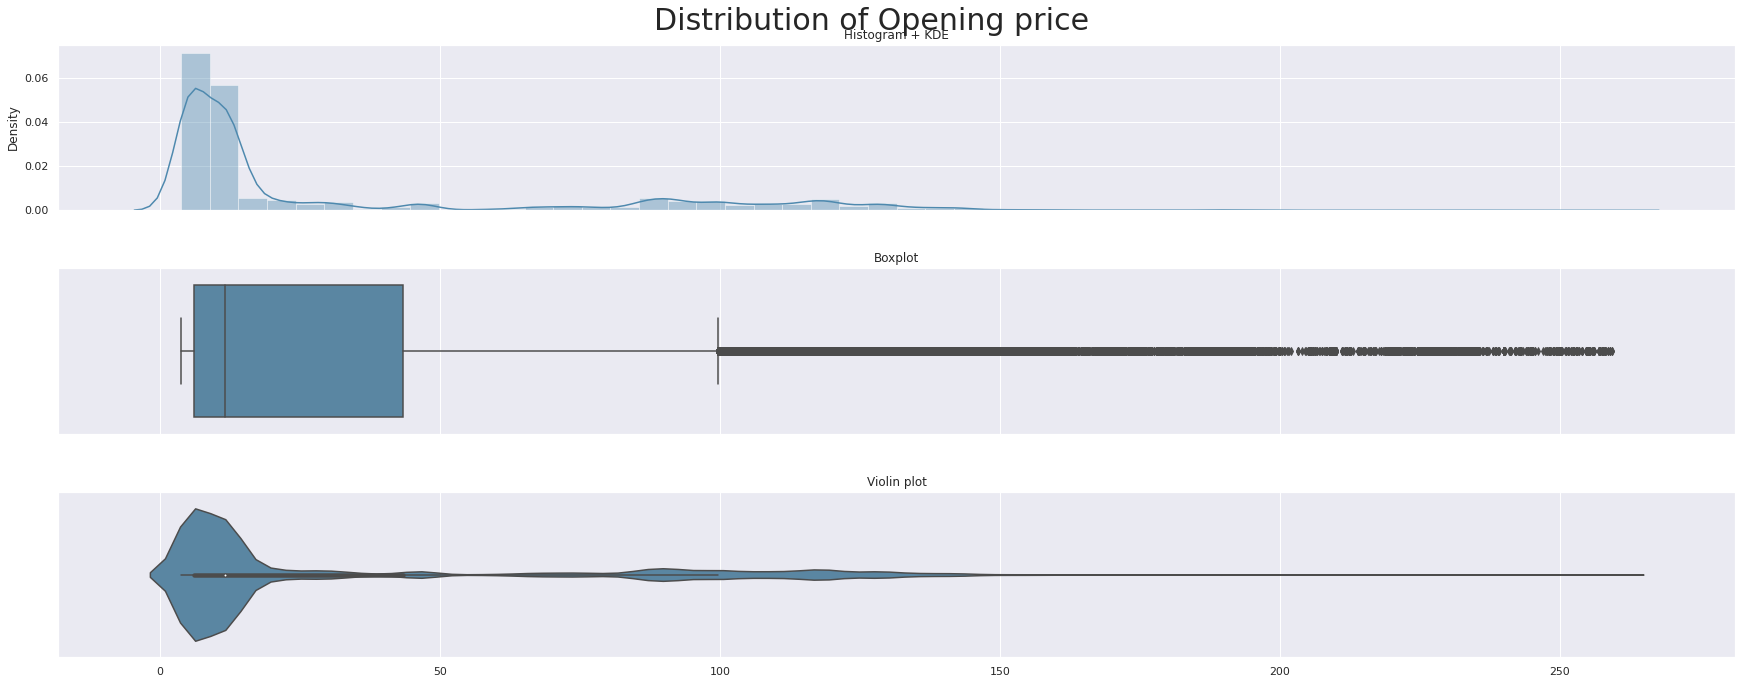

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm